In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
%matplotlib inline

import sklearn
print('Setup Complete')

Setup Complete


In [2]:
!pip install openpyxl

In [3]:
df = pd.read_excel('./data/Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.shape

(541909, 8)

Check for duplicates in the dataset and remove them from the data.

In [5]:
print('Duplicated entries: {}'.format(df.duplicated().sum()))
print('{}% rows are duplicate'.format(round((df.duplicated().sum()/df.shape[0])*100), 2))
df.drop_duplicates(inplace=True)

Duplicated entries: 5268
1% rows are duplicate


Check the total numnber of products, transactions and customers in the dataset

In [6]:
pd.DataFrame([{'products': len(df['StockCode'].value_counts()),
              'transactions': len(df['InvoiceNo'].value_counts()),
              'customers': len(df['CustomerID'].value_counts()),
              }], columns=['products', 'transactions', 'customers'], index=['quantity'])

,products,transactions,customers
quantity,4070,25900,4372


Checking country wise distributions of transactions

In [7]:
temp = df.groupby(['Country'], as_index=False).agg({'InvoiceNo': 'nunique'}).rename(columns={'InvoiceNo': 'Orders'})
total = temp['Orders'].sum(axis=0)
temp['%Orders'] = round((temp['Orders']/total)*100, 4)

In [8]:
temp.sort_values(by=['%Orders'], ascending=False, inplace=True)
temp.reset_index(drop=True, inplace=True)

Text(0, 0.5, '%Orders')

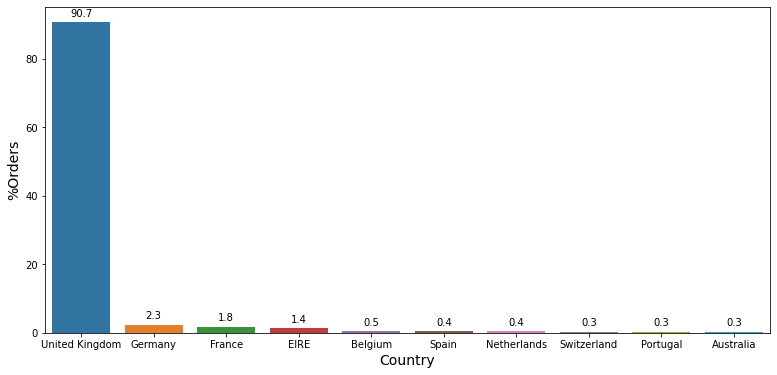

In [9]:
plt.figure(figsize=(13, 6))
splot = sns.barplot(x='Country', y='%Orders', data=temp[:10])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.1f'),
                  (p.get_x() + p.get_width() / 2., p.get_height()),
                  ha = 'center', va = 'center',
                  xytext = (0, 9),
                  textcoords = 'offset points')
plt.xlabel("Country", size=14)
plt.ylabel("%Orders", size=14)

We can see that 90% of the orders are coming in from the UK. For the purpose of this analysis we will only be looking at the data from the UK orders. The subset will be created in the next few steps.

Remove cancelled orders from the data.

In [10]:
invoices = df['InvoiceNo']

In [11]:
x = invoices.str.contains('C', regex=True)
x.fillna(0, inplace=True)
x = x.astype(int)
x.value_counts()

0    527390
1      9251
Name: InvoiceNo, dtype: int64

In [12]:
df['order_cancelled'] = x
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [13]:
df['order_cancelled'].value_counts()

0    527390
1      9251
Name: order_cancelled, dtype: int64

In [14]:
n1 = df['order_cancelled'].value_counts()[1]
n2 = df.shape[0]
print('Number of orders cancelled: {}/{} ({:.2f}%)'.format(n1, n2, n1/n2*100))

Number of orders cancelled: 9251/536641 (1.72%)


In [15]:
df = df.loc[df['order_cancelled'] == 0, :]
df.reset_index(drop=True, inplace=True)

We can check the dataset again to see if we have any negative quantities where the order wasn't cancelled

In [16]:
df.loc[df['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_cancelled
2336,536589,21777,NaN,-10,2010-12-01 16:50:00,0.0,NaN,United Kingdom,0
4249,536764,84952C,NaN,-38,2010-12-02 14:42:00,0.0,NaN,United Kingdom,0
7003,536996,22712,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7004,536997,22028,NaN,-20,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
7005,536998,85067,NaN,-6,2010-12-03 15:30:00,0.0,NaN,United Kingdom,0
...,...,...,...,...,...,...,...,...,...
520928,581210,23395,check,-26,2011-12-07 18:36:00,0.0,NaN,United Kingdom,0
520930,581212,22578,lost,-1050,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
520931,581213,22576,check,-30,2011-12-07 18:38:00,0.0,NaN,United Kingdom,0
522503,581226,23090,missing,-338,2011-12-08 09:56:00,0.0,NaN,United Kingdom,0


Notice how the `CustomerID` column has all NaN values with no unit price associated with it. We won't worry about what this means, we will just remove it from the dataset for now.

In [17]:
df = df[df['CustomerID'].notna()]

In [18]:
df.reset_index(drop=True, inplace=True)

In [19]:
# Now we will only use the orders that were from the UK since that accounts for 90% of our orders

df_uk = df[df['Country'] == 'United Kingdom']

In [20]:
df_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,order_cancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


In [21]:
df_uk.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 349227 entries, 0 to 392716
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        349227 non-null  object        
 1   StockCode        349227 non-null  object        
 2   Description      349227 non-null  object        
 3   Quantity         349227 non-null  int64         
 4   InvoiceDate      349227 non-null  datetime64[ns]
 5   UnitPrice        349227 non-null  float64       
 6   CustomerID       349227 non-null  float64       
 7   Country          349227 non-null  object        
 8   order_cancelled  349227 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 26.6+ MB


Luckily we don't have any missing values anymore, and we only have the orders from the UK. Let's create a new dataframe to look at the amount of products that were purchased, the total transactions and the number of customers.

In [22]:
# pd.DataFrame([[{'products': len(df['StockCode'].value_counts()),
#                'transactions': len(df['InoiceNo'].value_counts()),
#                'customers': len(df['CustomerID'].value_counts()),
#                }], columns= ['products', 'transactions', 'customers'], index=['quantity']])

pd.DataFrame([{'products': len(df['StockCode'].value_counts()),
              'transactions': len(df['InvoiceNo'].value_counts()),
              'customers': len(df['CustomerID'].value_counts()),
              }], columns=['products', 'transactions', 'customers'], index=['quantity'])

,products,transactions,customers
quantity,3665,18536,4339


### Cohort Analysis

A cohort is a set of users who share similar characteristics over time. Cohort analysis groups the users into mutually exclusive groups and their behaviour is measured over time.

It can provide information about product and customer lifecycle.

There are three types of cohort analysis:

1. Time cohorts: It groups customers by their purchase behaviour over time.
2. Behaviour cohorts: It groups customers by the product or service they signed up for.
3. Size cohorts: Refers to various sizes of customers who purchase company's products or services. This categorization can be based on the amount of spending in some period of time.

Understanding the needs of various cohorts can help a company design custom-made services or products for particular segments.

In the following analysis, we will create Time cohorts and look at customers who remain active during particular cohorts over a period of time that they transact over.

In [37]:
# Reverting back to data without the `order_cancelled` column
cohort_data = df_uk[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']]

In [24]:
# Checking for any nulls in the data
cohort_data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [25]:
all_dates = (pd.to_datetime(cohort_data['InvoiceDate'])).apply(lambda x: x.date())

In [26]:
(all_dates.max() - all_dates.min()).days

373

In [27]:
# Start and end dates
print('Start date: {}'.format(all_dates.min()))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-01
End date: 2011-12-09


In [28]:
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [29]:
def get_month(x):
    return dt.datetime(x.year, x.month, 1)

cohort_data['InvoiceMonth'] = cohort_data['InvoiceDate'].apply(get_month)
grouping = cohort_data.groupby('CustomerID')['InvoiceMonth']
cohort_data['CohortMonth'] = grouping.transform('min')
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01


In [30]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

invoice_year, invoice_month, _ = get_date_int(cohort_data, 'InvoiceMonth')
cohort_year, cohort_month, _ = get_date_int(cohort_data, 'CohortMonth')
years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month
cohort_data['CohortIndex'] = years_diff * 12 + months_diff
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,CohortIndex
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,2010-12-01,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,2010-12-01,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,2010-12-01,0


In [31]:
grouping = cohort_data.groupby(['CohortMonth', 'CohortIndex'])
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')
cohort_counts

CohortIndex,0,1,2,3,4,5,6,7,8,9,10,11,12
CohortMonth,,,,,,,,,,,,,
2010-12-01,815.0,289.0,263.0,304.0,293.0,323.0,291.0,278.0,289.0,325.0,299.0,405.0,218.0
2011-01-01,358.0,76.0,93.0,84.0,119.0,99.0,90.0,87.0,108.0,117.0,127.0,43.0,NaN
2011-02-01,340.0,64.0,66.0,97.0,98.0,86.0,87.0,96.0,90.0,104.0,25.0,NaN,NaN
2011-03-01,419.0,64.0,109.0,83.0,94.0,69.0,111.0,96.0,119.0,38.0,NaN,NaN,NaN
2011-04-01,277.0,58.0,56.0,60.0,56.0,61.0,61.0,73.0,20.0,NaN,NaN,NaN,NaN
2011-05-01,256.0,48.0,44.0,44.0,53.0,58.0,68.0,23.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,214.0,38.0,31.0,51.0,51.0,69.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,169.0,30.0,33.0,39.0,47.0,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,141.0,32.0,32.0,34.0,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


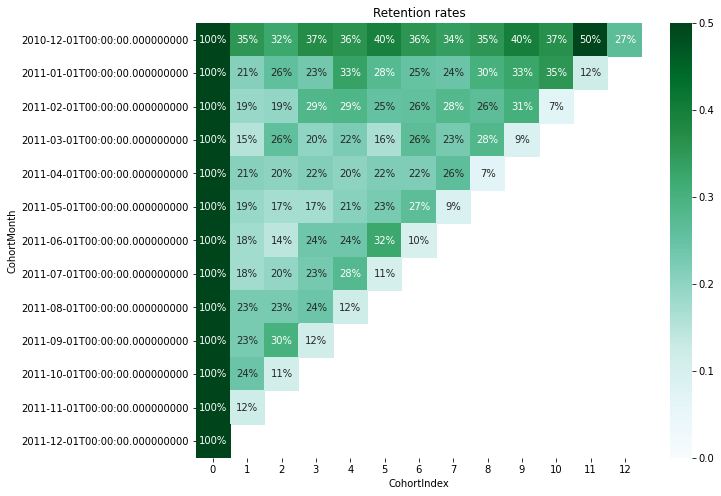

In [32]:
cohort_sizes = cohort_counts.iloc[:, 0]

retention = cohort_counts.divide(cohort_sizes, axis=0)

retention.round(3) * 100

plt.figure(figsize=(10, 8))
plt.title('Retention rates')
sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.5, cmap='BuGn')
plt.show();

### RFM Segmentation

RFM stands for recency, frequency, monetary. RFM analysis is a commonly used technique to generate and assign a score to each customer based on how recent their last transaction was (Recency), how many transations they have made in the last year (Frequency), and what the monetary value of their transactions are (Monetary).

In [33]:
import warnings
warnings.simplefilter('ignore')

In [38]:
cohort_data['totalSum'] = cohort_data['Quantity'] * cohort_data['UnitPrice']
cohort_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,totalSum
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


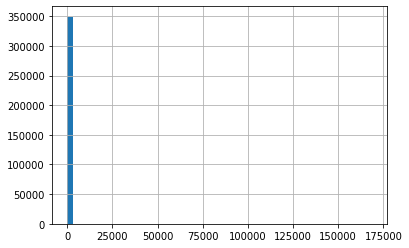

In [39]:
# Let's check the distribution of the totalSum column to understand customer spending
cohort_data.totalSum.hist(bins=50);

In [40]:
cohort_data.totalSum.describe()

count    349227.000000
mean         20.860428
std         328.406035
min           0.000000
25%           4.200000
50%          10.200000
75%          17.850000
max      168469.600000
Name: totalSum, dtype: float64

In [41]:
cohort_data[cohort_data['totalSum'] > 17.850000].sort_values('totalSum', ascending=False)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,totalSum
392266,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,2011-12-09 09:15:00,2.08,16446.0,United Kingdom,168469.60
36527,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60
153601,556444,22502,PICNIC BASKET WICKER 60 PIECES,60,2011-06-10 15:28:00,649.50,15098.0,United Kingdom,38970.00
116879,551697,POST,POSTAGE,1,2011-05-03 13:46:00,8142.75,16029.0,United Kingdom,8142.75
246062,567423,23243,SET OF TEA COFFEE SUGAR TINS PANTRY,1412,2011-09-20 11:05:00,5.06,17450.0,United Kingdom,7144.72
...,...,...,...,...,...,...,...,...,...
65572,545081,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-02-28 10:35:00,1.49,16057.0,United Kingdom,17.88
89499,547921,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-03-28 13:28:00,1.49,14766.0,United Kingdom,17.88
65822,545150,22558,CLOTHES PEGS RETROSPOT PACK 24,12,2011-02-28 12:27:00,1.49,14227.0,United Kingdom,17.88
31685,540691,21673,WHITE SPOT BLUE CERAMIC DRAWER KNOB,12,2011-01-11 08:50:00,1.49,17450.0,United Kingdom,17.88


In [42]:
# Now we'll check the max date and take the data a year behind the max date

from dateutil.relativedelta import relativedelta

start_date = all_dates.max() - relativedelta(months=12, days=-1)
print('Start date: {}'.format(start_date))
print('End date: {}'.format(all_dates.max()))

Start date: 2010-12-10
End date: 2011-12-09


In [43]:
data_rfm = cohort_data[cohort_data['InvoiceDate'] >= pd.to_datetime(start_date)]
data_rfm.reset_index(drop=True, inplace=True)
data_rfm.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,totalSum
0,538172,21562,HAWAIIAN GRASS SKIRT,12,2010-12-10 09:33:00,1.25,15805.0,United Kingdom,15.0
1,538172,79321,CHILLI LIGHTS,8,2010-12-10 09:33:00,4.95,15805.0,United Kingdom,39.6
2,538172,22041,"RECORD FRAME 7"" SINGLE SIZE",12,2010-12-10 09:33:00,2.55,15805.0,United Kingdom,30.6
3,538172,84558A,3D DOG PICTURE PLAYING CARDS,12,2010-12-10 09:33:00,2.95,15805.0,United Kingdom,35.4
4,538172,22952,60 CAKE CASES VINTAGE CHRISTMAS,24,2010-12-10 09:33:00,0.55,15805.0,United Kingdom,13.2


For RFM analysis, we need to define a 'snaphsot date' which is the day on which we are conducting this analysis. We'll take the snapshot date as the highest date in the data + 1 day so we get all of the updated information.

In [44]:
snapshot_date = max(data_rfm.InvoiceDate) + dt.timedelta(days=1)
print('Snapshot date: {}'.format(snapshot_date.date()))

Snapshot date: 2011-12-10


Next, we'll confine the data to a period of one year to limit the recency value to a maximum of 365 days and aggregate the data on a customer level and calculate the RFM metrics for each customer.

In [45]:
# Aggregate the data on a customer level
data = data_rfm.groupby(['CustomerID'], as_index=False).agg({'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
                                                            'InvoiceNo': 'count',
                                                            'totalSum': 'sum'}).rename(columns={'InvoiceDate': 'Recency',
                                                                                               'InvoiceNo': 'Frequency',
                                                                                               'totalSum': 'MonetaryValue'})

# check the first few rows
data.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326,1,77183.60
1,12747.0,2,96,3837.45
2,12748.0,1,4055,31081.74
3,12749.0,4,199,4090.88
4,12820.0,3,59,942.34


Now we'll add values ranging from 1 to 4 for recency, frequency, and monetary value. For recency, a value of 4 (the highest value) will be assigned to customers with the least recency value since they are the most recent customers. For frequency and monetary value, the highest value of 4 will be assigned to customers in the top 25% of the category.

In [46]:
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(data['Recency'], 4, labels=r_labels)
data = data.assign(R = r_quartiles.values)

f_labels = range(1, 5)
m_labels = range(1, 5)
f_quartiles = pd.qcut(data['Frequency'], 4, labels=f_labels)
m_quartiles = pd.qcut(data['MonetaryValue'], 4, labels=m_labels)
data = data.assign(F = f_quartiles.values)
data = data.assign(M = m_quartiles.values)
data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M
0,12346.0,326,1,77183.60,1,1,4
1,12747.0,2,96,3837.45,4,3,4
2,12748.0,1,4055,31081.74,4,4,4
3,12749.0,4,199,4090.88,4,4,4
4,12820.0,3,59,942.34,4,3,3


In [47]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) + str(x['M'])

data['RFM_segment'] = data.apply(join_rfm, axis=1)
data['RFM_score'] = data[['R', 'F', 'M']].sum(axis=1)
data.head()

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score
0,12346.0,326,1,77183.60,1,1,4,1.01.04.0,6
1,12747.0,2,96,3837.45,4,3,4,4.03.04.0,11
2,12748.0,1,4055,31081.74,4,4,4,4.04.04.0,12
3,12749.0,4,199,4090.88,4,4,4,4.04.04.0,12
4,12820.0,3,59,942.34,4,3,3,4.03.03.0,10


We can now analyze the RFM score distribution and their groups

In [48]:
data.groupby('RFM_score').agg({'Recency': 'mean',
                              'Frequency': 'mean',
                              'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_score                                      
3           242.6       7.9         149.8   324
4           171.0      13.7         224.3   353
5           147.6      20.0         351.1   456
6            87.4      27.0         807.3   432
7            80.8      38.9         717.1   399
8            56.3      52.0         930.3   397
9            43.8      73.5        1757.9   373
10           32.0     110.4        1869.3   389
11           20.6     183.7        3405.9   334
12            6.9     351.9        8027.9   398

As we can see, customers with the lowest RFM scores have the highest recency values and the lowest frequency and monetary value, and vice versa. 

We can also create basic segments of the cutomers based on the previous aggregation based on the RFM scores

In [49]:
def create_segment(df):
    if df['RFM_score'] >= 9:
        return 'Top'
    elif (df['RFM_score'] >= 5) and (df['RFM_score'] < 9):
        return 'Middle'
    else:
        return 'Bottom'
    
data['General_segment'] = data.apply(create_segment, axis=1)
data.groupby('General_segment').agg({'Recency': 'mean',
                                    'Frequency': 'mean',
                                    'MonetaryValue': ['mean', 'count']}).round(1)

Recency Frequency MonetaryValue      
                   mean      mean          mean count
General_segment                                      
Bottom            205.3      10.9         188.7   677
Middle             94.8      33.8         691.4  1684
Top                25.7     181.9        3825.7  1494

Note that we created basic logic for distributing customers into the 'Top', 'Middle', and 'Bottom' categories manually. In many scenarios this would be okay, but if we wanted to properly find out the segments on our RFM values, we can use a clustering algorithm such as K-Means.

### **Preprocessing data for Clustering**

Next we're going to prepare the data for K-Means clustering on RFM score data. To do this, we need to preprocess the data so that it can meet the key assumptions of K-Means algorithm which are:

1. The variables should be distributed symmetrically
2. Variables should have similar average values
3. Variables should have similar standard deviation values

<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

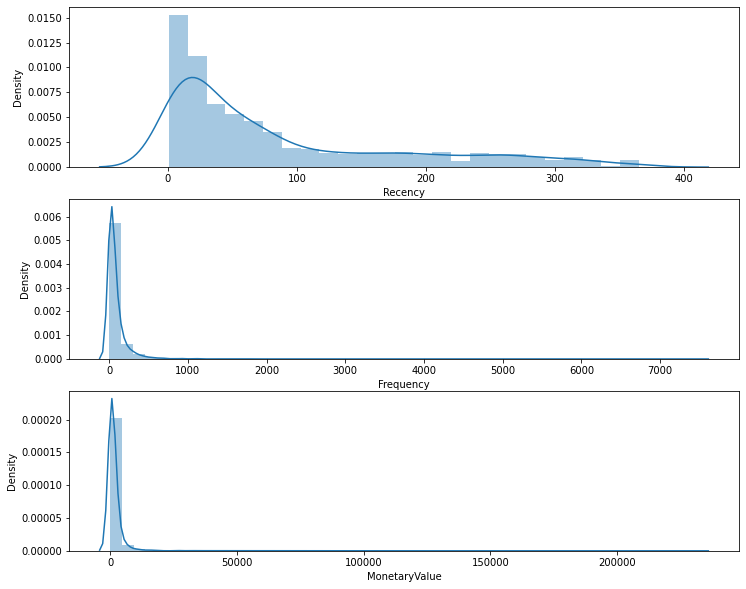

In [50]:
# Checking the distribution of Recency, Frequency and MonetaryValue
# variables

plt.figure(figsize=(12, 10))

# Plot the distribution recency
plt.subplot(3, 1, 1); sns.distplot(data['Recency'])

# Plot the distribution of frequency
plt.subplot(3, 1, 2); sns.distplot(data['Frequency'])

# Plot the distribution of monetary value
plt.subplot(3, 1, 3); sns.distplot(data['MonetaryValue'])

We can see form the above plots that all the variables do not have symmetrical distribution. All of them are skewed to the right. To remove skewness, we can try the following transformations:

1. log transformations
2. Box-cox transformations
3. Cube root transformations

The log transformation cannot be used for negative values. One common practice to use here is to add a constant value to get a positive value and this is generally taken as the absolute of the negative value of the variable to each observation. However, in our data, we do not have any negative values since we are dealing with customer transactions dataset

In [51]:
# Checking for constant mean and variance
data[['Recency', 'Frequency', 'MonetaryValue']].describe()

,Recency,Frequency,MonetaryValue
count,3855.000000,3855.000000,3855.000000
mean,87.428016,87.205966,1817.792603
std,93.428162,209.411865,7190.041841
min,1.000000,1.000000,0.000000
25%,17.000000,16.000000,291.680000
50%,50.000000,40.000000,638.060000
75%,134.000000,96.000000,1545.515000
max,365.000000,7491.000000,231822.690000


From the above description, we can see that the minimum MonetaryValue for a particular customerID is 0. This transaction does not make sense so we need to remove it from the data.

We also see that we do not get constant mean and standard deviation values.

Removing the customer with 0 MonetaryValue from the data:

In [52]:
data[data['MonetaryValue'] ==0]

,CustomerID,Recency,Frequency,MonetaryValue,R,F,M,RFM_segment,RFM_score,General_segment
310,13256.0,14,1,0.0,4,1,1,4.01.01.0,6,Middle


In [54]:
data = data[data['MonetaryValue'] > 0]
data.reset_index(drop=True, inplace=True)

In [55]:
raw_data = data[['Recency', 'Frequency', 'MonetaryValue']]

In [56]:
from sklearn.preprocessing import StandardScaler
# Let's now apply log transformation to the data and normalize it

# Unskew the data
data_log = np.log(raw_data)

# initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(data_log)

# Scale and center the data
data_normalized = scaler.transform(data_log)

# Create a pandas DataFrame
data_norm = pd.DataFrame(data=data_log, index=raw_data.index, columns=raw_data.columns)

In [57]:
data_norm.head()

,Recency,Frequency,MonetaryValue
0,5.786897,0.000000,11.253942
1,0.693147,4.564348,8.252563
2,0.000000,8.307706,10.344376
3,1.386294,5.293305,8.316515
4,1.098612,4.077537,6.848366


<AxesSubplot:xlabel='MonetaryValue', ylabel='Density'>

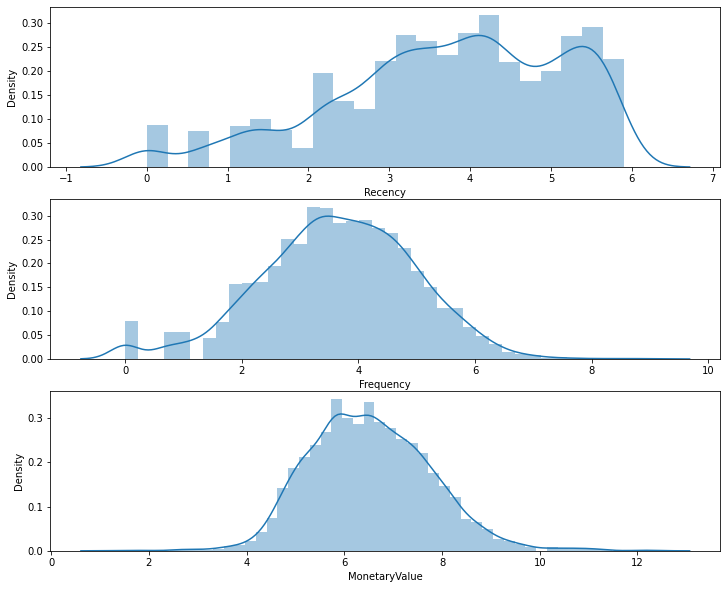

In [58]:
# Check the skewness in the data now

plt.figure(figsize=(12, 10))

# plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(data_norm['Recency'])

# plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(data_norm['Frequency'])

# plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(data_norm['MonetaryValue'])

### **Clustering K-Means algorithm**

Now we'll build multiple clusters on our RFM data (data_norm) and will try to find out optimal number of clusters in our data using the elbow method.

In [60]:
from sklearn.cluster import KMeans

In [61]:
sse = {}

# Fit KMeans and calculate SSE for each K
for k in range(1, 21):
    
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_norm)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

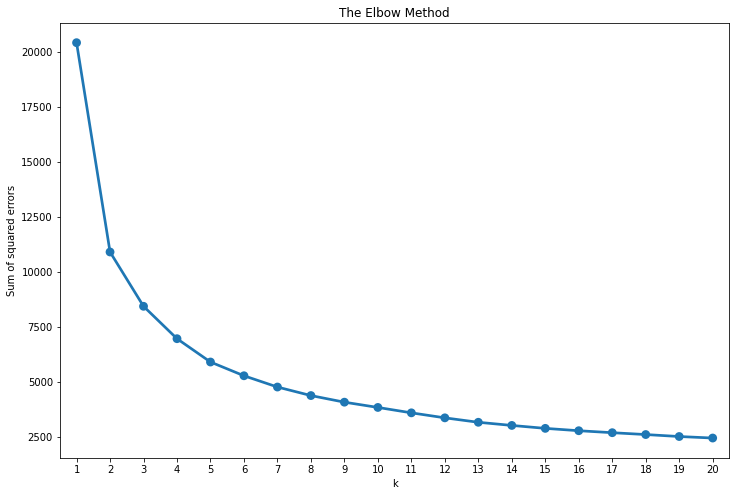

In [62]:
plt.figure(figsize=(12, 8))

plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show();

In [63]:
kmeans = KMeans(n_clusters=3, random_state=42)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

cluster_labels = kmeans.labels_

In [64]:
# Create a cluster label column in the original DataFrame
data_norm_k3 = data_norm.assign(Cluster=cluster_labels)
data_k3 = raw_data.assign(Cluster=cluster_labels)

# Calculating average RFM values and size for each cluster
summary_k3 = data_k3.groupby(['Cluster']).agg({'Recency': 'mean',
                                              'Frequency': 'mean',
                                              'MonetaryValue': ['mean', 'count']}).round(0)
summary_k3

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         164.0      14.0         284.0  1329
1          67.0      66.0        1159.0  1654
2          11.0     239.0        5410.0   871

In [65]:
kmeans = KMeans(n_clusters=4, random_state=42)

# Compute k-means clustering on pre-processed data
kmeans.fit(data_norm)

cluster_labels = kmeans.labels_

In [68]:
# Create a cluster label column in the original DataFrame
data_norm_k4 = data_norm.assign(Cluster=cluster_labels)
data_k4 = raw_data.assign(Cluster=cluster_labels)

# Calculate average RFM values and size for each cluster
summary_k4 = data_k4.groupby(['Cluster']).agg({'Recency': 'mean',
                                             'Frequency': 'mean',
                                             'MonetaryValue': ['mean', 'count']}).round(0)
summary_k4

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         178.0      15.0         293.0  1216
1          21.0      34.0         525.0   770
2          10.0     269.0        6197.0   721
3          85.0      85.0        1551.0  1147

In [69]:
display(summary_k3)
display(summary_k4)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         164.0      14.0         284.0  1329
1          67.0      66.0        1159.0  1654
2          11.0     239.0        5410.0   871

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         178.0      15.0         293.0  1216
1          21.0      34.0         525.0   770
2          10.0     269.0        6197.0   721
3          85.0      85.0        1551.0  1147

In [70]:
data_norm_k4.index = data['CustomerID'].astype(int)

In [71]:
data_norm_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,5.786897,0.000000,11.253942,3
12747,0.693147,4.564348,8.252563,2
12748,0.000000,8.307706,10.344376,2
12749,1.386294,5.293305,8.316515,2
12820,1.098612,4.077537,6.848366,2


In [72]:
# Melt the data into along format so RFM values and metric names are stored in 1 column each
data_melt = pd.melt(data_norm_k4.reset_index(),
                    id_vars=['CustomerID', 'Cluster'],
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'],
                    var_name='Attribute',
                    value_name='Value')

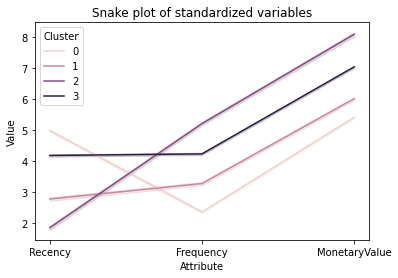

In [73]:
plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=data_melt);

We can also use the following method to understand the relative importance of segments in the data. To do this, we will complete the following steps:

1. Calculate average values of each cluster
2. Calculate average values of population
3. Calculate importance score by dividing them and subtracting 1 (ensures 0 is returned when cluster average equals population average)


Assigning CustomerID index to data_k4 dataframe:

In [74]:
data_k4.index = data['CustomerID'].astype(int)
data_k4.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,326,1,77183.60,3
12747,2,96,3837.45,2
12748,1,4055,31081.74,2
12749,4,199,4090.88,2
12820,3,59,942.34,2


Assigning CustomerID index to raw_data dataframe:

In [75]:
raw_data.index = data['CustomerID'].astype(int)
raw_data.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12747,2,96,3837.45
12748,1,4055,31081.74
12749,4,199,4090.88
12820,3,59,942.34


In [76]:
cluster_avg = data_k4.groupby(['Cluster']).mean()
population_avg = raw_data.head().mean()

In [77]:
cluster_avg

,Recency,Frequency,MonetaryValue
Cluster,,,
0,178.092928,14.846217,293.134425
1,21.358442,34.475325,525.498494
2,9.758669,268.549237,6196.815354
3,84.549259,85.401046,1550.655024


In [78]:
population_avg

Recency             67.200
Frequency          882.000
MonetaryValue    23427.202
dtype: float64

In [80]:
relative_imp = cluster_avg / population_avg - 1
relative_imp.round(2)

,Recency,Frequency,MonetaryValue
Cluster,,,
0,1.65,-0.98,-0.99
1,-0.68,-0.96,-0.98
2,-0.85,-0.70,-0.74
3,0.26,-0.90,-0.93


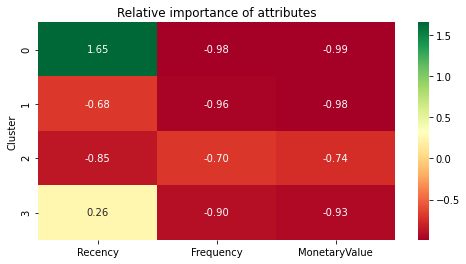

In [81]:
# Plot heatmap
plt.figure(figsize=(8, 4))
plt.title('Relative importance of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show();